In [4]:
import arlpy
import cv2
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline 

Reading the test image to produce signal

size: (225, 400, 3)


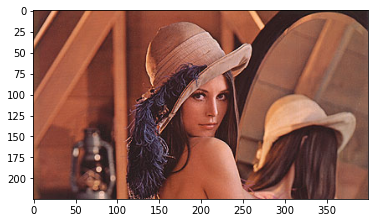

In [6]:
img=plt.imread("len_top.jpg")
img=np.asarray(img)

plt.imshow(img)
size=np.shape(img)
print("size:",size)
bitpic=bytearray(img)
s=np.size(img)

OFDM parameters 

In [67]:
K=64 #no of subcarries of OFDM system 
CP=int(K/4)   #len of cyclic prefix :25%
P=8 #no of carrier for pilot
pilotValue=3+3j




allCarriers:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
pilotCarriers: [ 0  8 16 24 32 40 48 56 63]
dataCarriers:  [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 25 26 27
 28 29 30 31 33 34 35 36 37 38 39 41 42 43 44 45 46 47 49 50 51 52 53 54
 55 57 58 59 60 61 62]


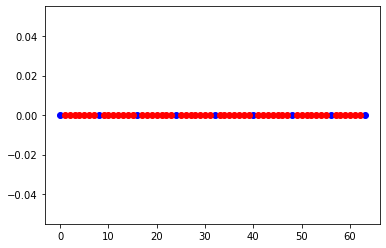

In [8]:
allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])

pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier.

# For convenience of channel estimation, let's make the last carriers also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P+1

# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)

print ("allCarriers:   %s" % allCarriers)
print ("pilotCarriers: %s" % pilotCarriers)
print ("dataCarriers:  %s" % dataCarriers)
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')

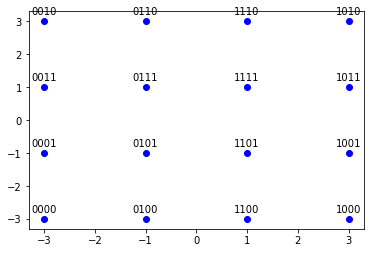

In [9]:
mu = 4 # bits per symbol (i.e. 16QAM)
payloadBits_per_OFDM = len(dataCarriers)*mu  # number of payload bits per OFDM symbol

mapping_table = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j
}
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')

In [10]:
demapping_table = {v : k for k, v in mapping_table.items()}

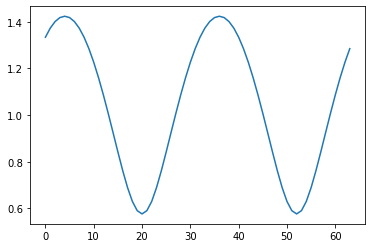

In [11]:
channelResponse = np.array([1, 0, 0.3+0.3j])  # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, K)
plt.plot(allCarriers, abs(H_exact))



In [18]:
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
print ("Bits count: ", len(bits))
print ("First 20 bits: ", bits[:20])
print ("Mean of bits (should be around 0.5): ", np.mean(bits))

Bits count:  220
First 20 bits:  [0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 0]
Mean of bits (should be around 0.5):  0.5272727272727272


encodeing image into bits with dtype=uint8

In [13]:
# def imgtobit(i):
#     i=np.reshape(i,[-1,1])
#     b = np.unpackbits(i, axis=-1)
#     return b

In [14]:
# bits=imgtobit(img)

In [19]:
def SP(bits):
    return bits.reshape([-1,4])
bits_SP = SP(bits)


Mapping to QAM-16

In [20]:
def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM = Mapping(bits_SP)
# QAM = np.reshape(QAM,[-1,54])
print ("First 5 QAM symbols and bits:")
print (bits_SP[:5,:])
print (QAM[:5])

First 5 QAM symbols and bits:
[[0 1 1 1]
 [0 0 0 1]
 [1 0 0 0]
 [1 1 1 1]
 [0 0 1 0]]
[-1.+1.j -3.-1.j  3.-3.j  1.+1.j -3.+3.j]


In [21]:
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers 
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol
OFDM_data = OFDM_symbol(QAM)
print ("Number of OFDM carriers in frequency domain: ", len(OFDM_data))

Number of OFDM carriers in frequency domain:  64


In [22]:
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
OFDM_time = IDFT(OFDM_data)
print ("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))

Number of OFDM samples in time-domain before CP:  64


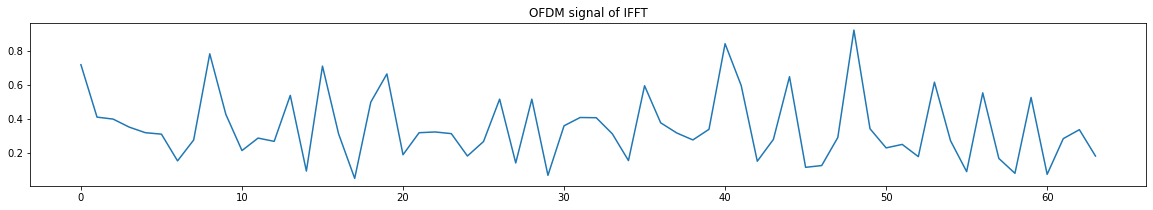

In [60]:
plt.figure(figsize=(20,3))
plt.plot(abs(OFDM_time))
plt.title("OFDM signal of IFFT")
plt.show()

ADD GAURD TIME

In [24]:
def addCP(OFDM_time):
    cp = OFDM_time[-16:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning

OFDM_withCP = addCP(OFDM_time)
print ("Number of OFDM samples in time domain with CP: ", len(OFDM_withCP))

Number of OFDM samples in time domain with CP:  80


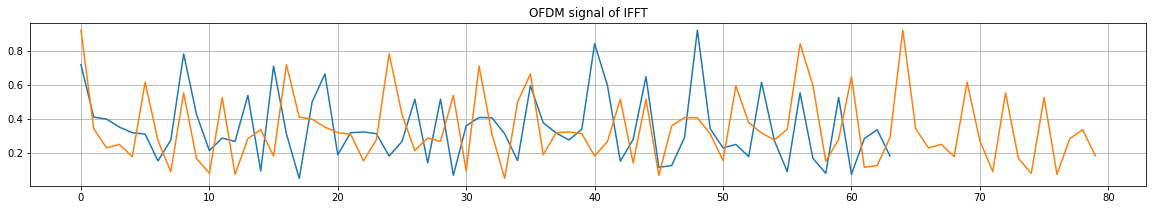

In [61]:
t=np.arange(0,80,0.5)
# plt.subplot(1,2,2)
plt.figure(figsize=(20,3))
plt.plot(abs(OFDM_time))
plt.plot(abs(OFDM_withCP))
plt.grid()
plt.title("OFDM signal of IFFT")
plt.show()

CHANNEL START with bell hop ray tracing model to simulate acoousticc communication

 The depth of water column is 100 m and the range between transmitter and receiver is approximately 1000 m. As expressed to be a function of temperature, salinity and depth, the sound speed increases from 1527 m/s at the surface of the water column to 1530 m/s at the bottom. In the sediment layer, the sound speed is 1650 m/s and the attenuation coefficient is 0.8 dB/λ . The density of water is 1.0 g/cm3 and that of the sediment layer is 1.9 g/cm3. Based on the schematic diagram of BELLHOP ray model in Fig. 7, two different UWA multipath channels with three taps and seven taps are modeled to investigate the performance of UWA-OFDM systems, labeled by channel-I and channel-II, respectively.

RX Signal power: 0.1822. Noise power: 0.0576


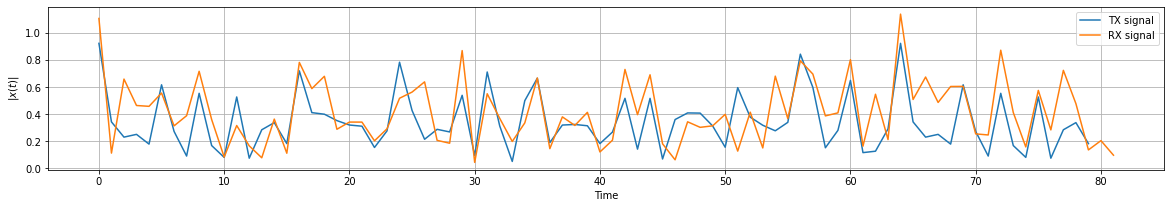

In [130]:
SNRdb=5
def channel(signal):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
    
    print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise
OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX)
plt.figure(figsize=(20,3))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel('Time'); plt.ylabel('$|x(t)|$');
plt.grid(True);

In [131]:
def removeCP(signal):
    return signal[CP:(CP+K)]
OFDM_RX_noCP = removeCP(OFDM_RX)

In [132]:
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)
OFDM_demod = DFT(OFDM_RX_noCP)

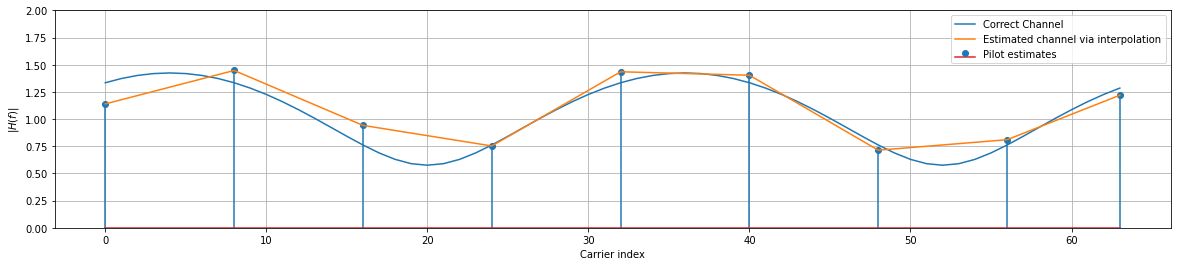

In [133]:
import scipy
def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values
    
    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase 
    # separately
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    plt.figure(figsize=(20,4))
    plt.plot(allCarriers, abs(H_exact), label='Correct Channel')
    plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates')
    plt.plot(allCarriers, abs(Hest), label='Estimated channel via interpolation')
    plt.grid(True); plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=10)
    plt.ylim(0,2)
    
    return Hest
Hest = channelEstimate(OFDM_demod)

In [134]:
def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest
equalized_Hest = equalize(OFDM_demod, Hest)

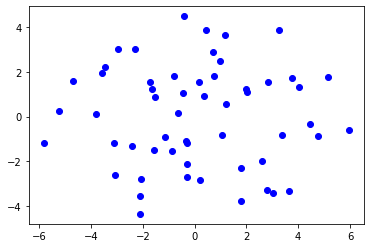

In [135]:
def get_payload(equalized):
    return equalized[dataCarriers]
QAM_est = get_payload(equalized_Hest)
plt.plot(QAM_est.real, QAM_est.imag, 'bo');

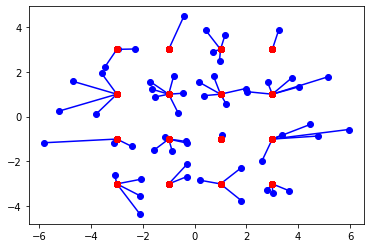

In [136]:
def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # get back the real constellation point
    hardDecision = constellation[const_index]
    
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

PS_est, hardDecision = Demapping(QAM_est)
for qam, hard in zip(QAM_est, hardDecision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
    plt.plot(hardDecision.real, hardDecision.imag, 'ro')

In [137]:
def PS(bits):
    return bits.reshape((-1,))
bits_est = PS(PS_est)

In [140]:
print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_est))/len(bits))

Obtained Bit error rate:  0.17727272727272728


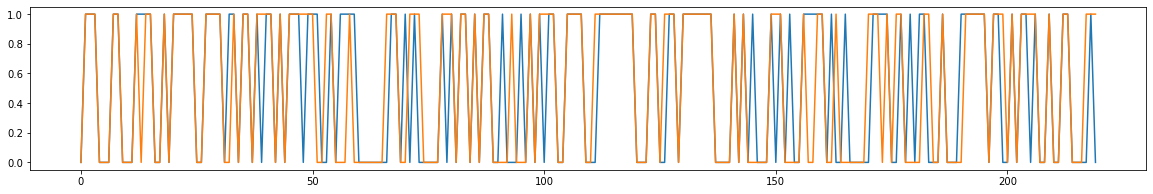

In [139]:
plt.figure(figsize=(20,3))

plt.plot(bits)
plt.plot(bits_est)

In [141]:
import arlpy.uwapm as pm
import arlpy.plot as plt
import numpy as np

In [142]:
pm.models()

[]